<a href="https://colab.research.google.com/github/Ahmed-Camara/Walk_or_Run/blob/main/Walk_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
import matplotlib.pyplot as plt
import os

In [3]:
base_dir = '/content/drive/MyDrive/ML_DL_practice/Walk_or_Run/data/walk_run.zip'
import zipfile
with zipfile.ZipFile(base_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset/')

In [4]:
train_path = '/content/dataset/walk_or_run_train/train'
test_path = '/content/dataset/walk_or_run_test/test'
os.listdir(train_path)

['run', 'walk']

In [5]:
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)

In [6]:
train_dataset = image_dataset_from_directory(train_path,shuffle=True,validation_split=0.3,
                                             image_size=IMAGE_SIZE,subset='training', seed = 42)

validation_dataset = image_dataset_from_directory(train_path,shuffle=True,validation_split=0.3,subset='validation',
                                                  image_size=IMAGE_SIZE, seed = 42)

test_dataset = image_dataset_from_directory(test_path,shuffle=True
                                                  ,image_size=IMAGE_SIZE
                                                  , seed = 42)

Found 600 files belonging to 2 classes.
Using 420 files for training.
Found 600 files belonging to 2 classes.
Using 180 files for validation.
Found 141 files belonging to 2 classes.


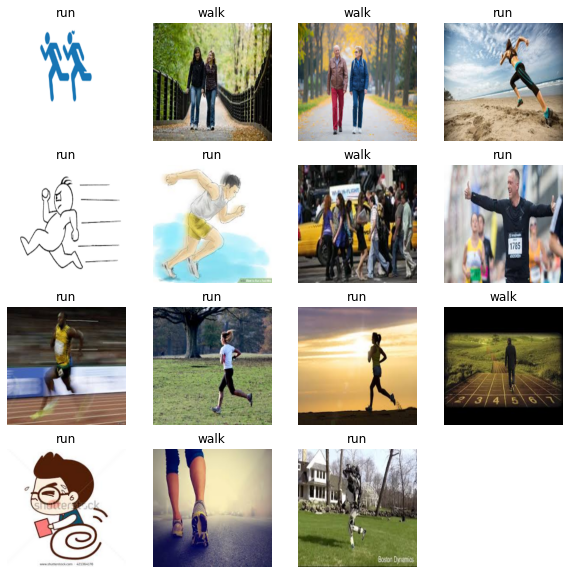

In [7]:
class_names = train_dataset.class_names
class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(15):
        ax = plt.subplot(4,4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    return data_augmentation

In [9]:
IMAGE_SHAPE = IMAGE_SIZE + (3,)

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE,
                                             include_top=False,weights='imagenet')
data_augmentation = data_augmenter()
base_model.trainable = False 
inputs = tf.keras.Input(shape=IMAGE_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dropout(0.5)(x)
outputs = tfl.Dense(2)(x)
model = tf.keras.Model(inputs, outputs)

In [11]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,restore_best_weights=True)
callbacks = [stop_early]

In [12]:
loss_function=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics=['accuracy']

model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

history = model.fit(train_dataset,
                         epochs=50,batch_size=BATCH_SIZE,
                         validation_data=validation_dataset,callbacks=callbacks)

Epoch 1/50
14/14 [==============================] - 25s 2s/step - loss: 1.0555 - accuracy: 0.5690 - val_loss: 0.6286 - val_accuracy: 0.6500
Epoch 2/50
14/14 [==============================] - 23s 2s/step - loss: 0.7715 - accuracy: 0.6476 - val_loss: 0.5810 - val_accuracy: 0.6778
Epoch 3/50
14/14 [==============================] - 21s 1s/step - loss: 0.8203 - accuracy: 0.6452 - val_loss: 0.5202 - val_accuracy: 0.7611
Epoch 4/50
14/14 [==============================] - 21s 1s/step - loss: 0.7327 - accuracy: 0.6405 - val_loss: 0.4866 - val_accuracy: 0.7500
Epoch 5/50
14/14 [==============================] - 20s 1s/step - loss: 0.7207 - accuracy: 0.6690 - val_loss: 0.4781 - val_accuracy: 0.7889
Epoch 6/50
14/14 [==============================] - 20s 1s/step - loss: 0.6821 - accuracy: 0.6976 - val_loss: 0.4553 - val_accuracy: 0.7611
Epoch 7/50
14/14 [==============================] - 20s 1s/step - loss: 0.6350 - accuracy: 0.6786 - val_loss: 0.4683 - val_accuracy: 0.8000
Epoch 8/50
14/14 [==

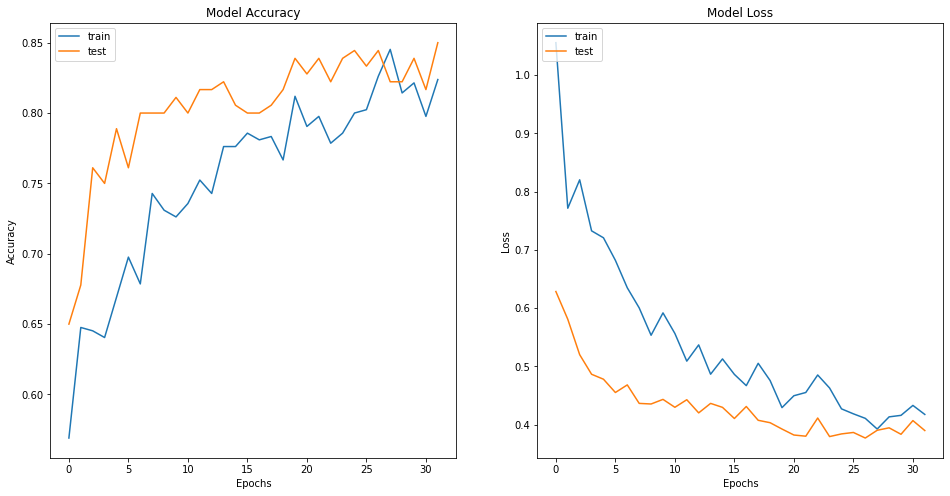

In [13]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (16, 8))


ax0.plot(history.history['accuracy'])
ax0.plot(history.history['val_accuracy'])
ax0.set_title('Model Accuracy')
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Accuracy')
ax0.legend(['train', 'test'], loc='upper left')



ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Model Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(['train', 'test'], loc='upper left')

plt.show()

In [14]:
results = model.evaluate(test_dataset)
print("test loss, test acc:", results)

5/5 [==============================] - 4s 729ms/step - loss: 0.4040 - accuracy: 0.8156
test loss, test acc: [0.40403732657432556, 0.8156028389930725]


In [15]:
model_path = '/content/drive/MyDrive/ML_DL_practice/Walk_or_Run/model'
model.save(model_path+'/walk_run.h5')